In [1]:
import bbmaster as mst
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import healpy as hp

### 1. Setup
- Read mask.
- Define bandpower bins
- Initialize bandpower window function calculator

In [2]:
# Read mask
nside = 64
#msk = hp.read_map("../SensitivityCheck/data/mask_apodized.fits")
#msk = hp.read_map("/global/cscratch1/sd/kwolz/BBPower/examples/data/maps/mask_bin_apo10.0_nside64.fits")
msk = np.ones(hp.nside2npix(nside))
# Generate NaMaster bins
b = nmt.NmtBin(nside, nlb=10)
# Bbl calculator
# Dictionary defining method to generate delta sims (not many options yet!)
dsim = {'stats': 'Gaussian'}
# Dictionary defining method to filter (just masking for now)
filt = {'mask': msk}
bc = mst.DeltaBbl(nside, dsim, filt, b)

### 2. Compute exact bandpowers
Now let's use NaMaster to compute the exact bandpower windows, and plot them

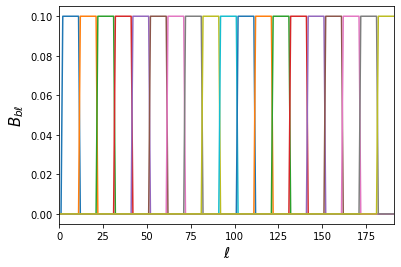

In [3]:
f = nmt.NmtField(hp.ud_grade(msk, nside_out=nside), None, spin=0)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f, f, b)
mcm = w.get_coupling_matrix()

bpw_true = np.array([b.bin_cell(m) for m in mcm.T]).T

for bpw in bpw_true:
    plt.plot(bpw)
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15);

### 3. Compute bandpower windows through simulations

In [4]:
bpw_num = bc.gen_Bbl_all()

/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


Now compute them using $Z_2$ rather than Gaussian sims

In [5]:
dsim = {'stats': 'Z2'}
bc_z2 = mst.DeltaBbl(nside, dsim, filt, b)
bpw_num_z2 = bc_z2.gen_Bbl_all()

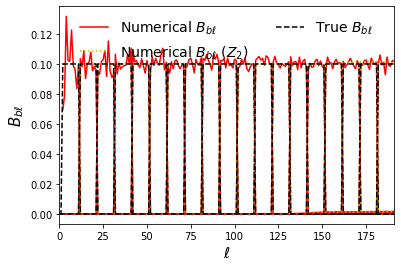

In [6]:
for bpw_t, bpw_n, bpw_z2 in zip(bpw_true, bpw_num, bpw_num_z2):
    plt.plot(bc.get_ells(), bpw_n, 'r-')
    plt.plot(bc.get_ells(), bpw_z2, 'y:')
    plt.plot(bpw_t, 'k--')
plt.plot([-1], [0], 'r-', label='Numerical $B_{b\ell}$')
plt.plot([-1], [0], 'y:', label='Numerical $B_{b\ell}\,\,(Z_2)$')
plt.plot([-1], [0], 'k--', label='True $B_{b\ell}$')
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15)
plt.legend(ncol=2, loc='upper center', fontsize=14, frameon=False);

Uuuh, notice the crap in the last few bandpowers? This is all HEALPix rubbish for $\ell>2 N_{\rm side}$, so just a reminder that we need to throw that away!

In [7]:
alm = hp.Alm()
sqrt2 = np.sqrt(2.)
oosqrt2 = 1/sqrt2

def get_dmap(ell):
    idx = alm.getidx(3*nside-1, ell, np.arange(ell+1))
    rans = oosqrt2*(2*np.random.binomial(1, 0.5, size=2*(ell+1))-1).reshape([2, ell+1])
    rans[0, 0] *= sqrt2
    rans[1, 0] = 0
    alms = np.zeros(alm.getsize(3*nside-1), dtype='complex128')
    alms[idx] = rans[0]+1j*rans[1]
    print(hp.alm2cl(alms)[ell])
    return hp.alm2map(alms, nside)

0.9999999999999998
0.9999999999999998


/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


0.9999999999999998


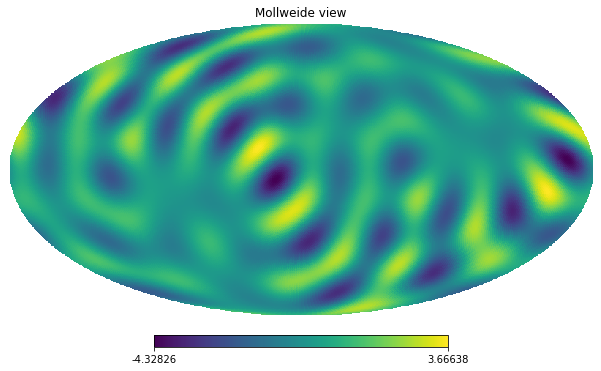

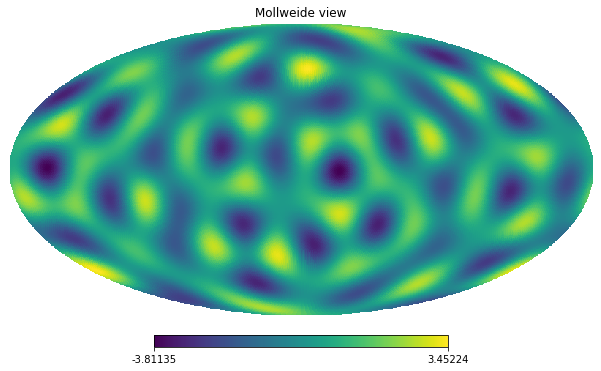

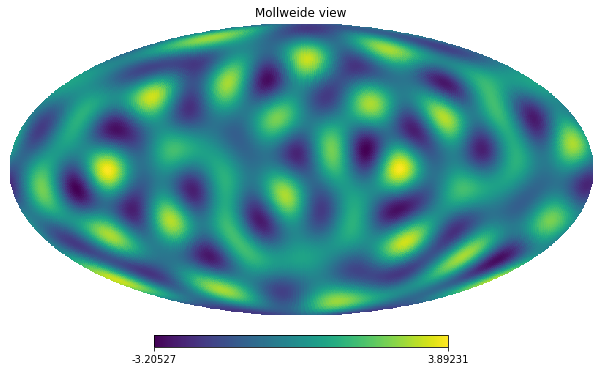

In [8]:
hp.mollview(get_dmap(10))
hp.mollview(get_dmap(10))
hp.mollview(get_dmap(10))


In [9]:
print(hp.alm2cl(alms))

NameError: name 'alms' is not defined

In [ ]:
np.mean((2*np.random.binomial(1, 0.5, size=100)-1)/np.sqrt(2))

In [ ]:
alm = hp.map2alm(np.random.randn(hp.nside2npix(nside)))

In [ ]:
alm.dtype